# Structure Characterization

In [2]:
%load_ext autoreload
%autoreload 2

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import glob
from matplotlib.ticker import ScalarFormatter
from skimage.feature import peak_local_max

from m3util.viz.layout import layout_fig, layout_subfigures_inches
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines
from xrd_learn.xrd_viz import plot_xrd
from xrd_learn.xrd_utils import detect_peaks, calculate_fwhm, load_xrd_scans, align_peak_to_value
from xrd_learn.rsm_viz import RSMPlotter
from afm_learn.afm_viz import visualize_afm_image
from afm_learn.afm_utils import parse_ibw, format_func
from sro_sto_plume.coordinate_converter import convert_top_left_origin_to_matplotlib
from sro_sto_plume.xrd_ref import calculate_2theta, plot_ref_xrd
from sro_sto_plume.packed_plot_functions import plot_xrd_figure, set_fig_axes, plot_rsm_figure, plot_fwhm_line_profile_figure, plot_fwhm_trend_figure

colors = colormaps.get_cmap('tab10').colors[:6]

## 1. AFM

## 2. XRD

### 2.1 XRD Summary

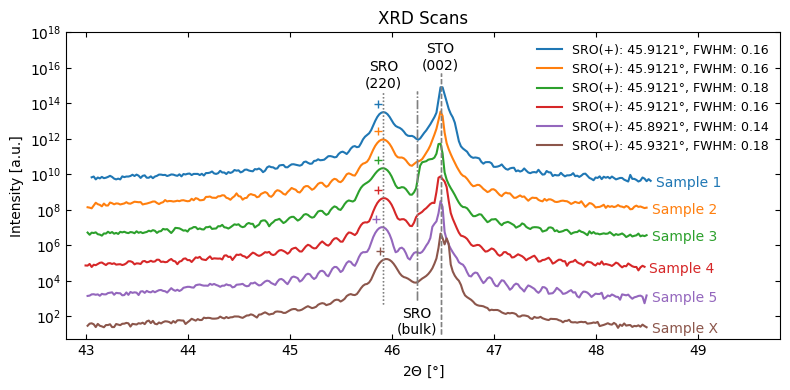

In [8]:
fig, ax = layout_fig(graph=1, mod=1, figsize=(8, 4), layout='tight')
plot_xrd_figure(fig, ax, filename=None)
plt.show()

### 2.2 Reference XRD Peaks

In [4]:
# Example: SrTiO3 (002) reflection
two_theta_value = calculate_2theta(hkl=(0, 0, 2), abc=(3.905, 3.905, 3.905))
print(f"2θ for STO (002) reflection: {two_theta_value:.4f}°")

two_theta_value = calculate_2theta(hkl=(2, 2, 0), abc=(5.567, 5.530, 7.845))
print(f"2θ for SRO (220) reflection: {two_theta_value:.4f}°")

2θ for STO (002) reflection: 46.4721°
2θ for SRO (220) reflection: 46.2425°


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

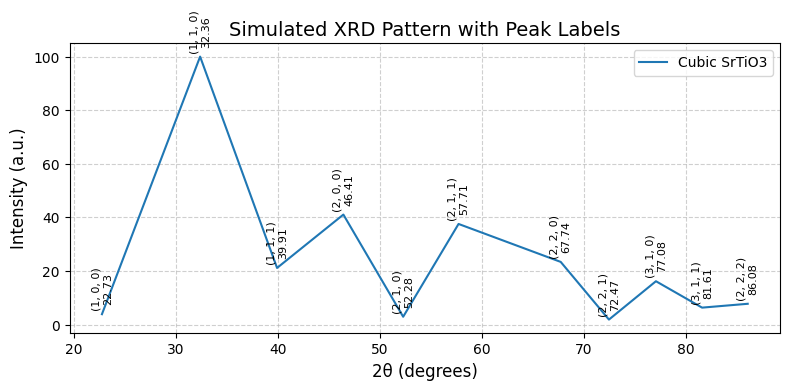

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

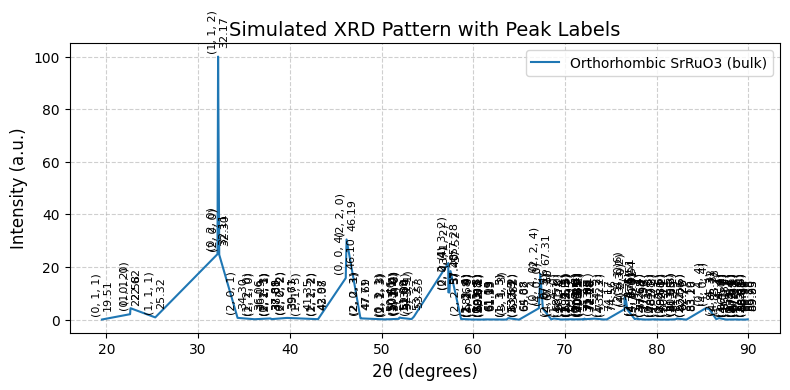

In [6]:
api_key = 'fpkmDzflX03EpKg0aOsda6u6aLJ7Bkpm'
plot_ref_xrd(api_key=api_key, material_id='mp-5229', label='Cubic SrTiO3') # Cubic SrTiO3
plot_ref_xrd(api_key=api_key, material_id='mp-22390', label='Orthorhombic SrRuO3 (bulk)') # Orthorhombic SrRuO3

### 2.3 XRD and Peaks

In [2]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
        '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG063/YG063 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',]
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
STO_x_peak = 46.4721
SRO_bulk_x_peak = 46.2425

Xs, Ys, length_list = load_xrd_scans(files)
for i, (X, Y, sample_name) in enumerate(zip(Xs, Ys, sample_names)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

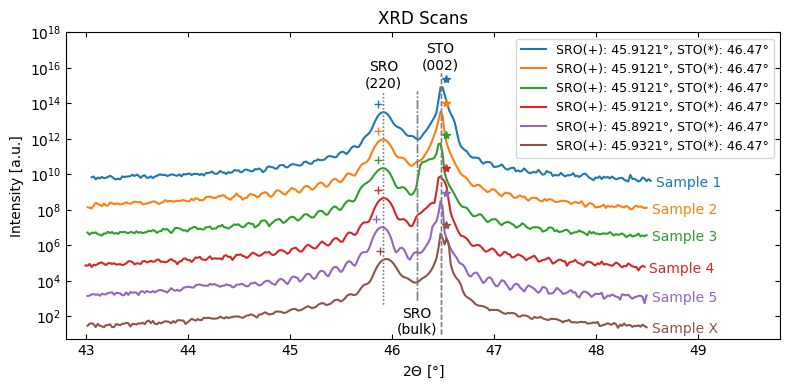

In [3]:
fig, ax = layout_fig(1, 1, figsize=(8, 4), layout='tight')
diff = 5e1
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 5e15], style=line_style)
ax.text(STO_x_peak, 8e15, 'STO\n(002)', fontsize=10, ha='center')

ax.text(45.9121, 8e14, 'SRO\n(220)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[45.9121, 45.9121], y_values=[5e2, 5e14], style=line_style)

ax.text(SRO_bulk_x_peak, 10, 'SRO\n(bulk)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dashdot', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[8e2, 5e14], style=line_style)

legend = []
for i, (X, Y, sample_name, color) in enumerate(zip(Xs_aligned, Ys_aligned, sample_names, colors)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend.append(legend_item)
    
    peak_y = np.array(peak_y)*diff**(len(Ys)-i-1)
    plt.plot(peak_x[0]+0.05, peak_y[0]*3, '*', color=color)
    plt.plot(peak_x[1]-0.05, peak_y[1]*3, '+', color=color)
    
plt.ylim(5, 1e18)
plt.legend(legend, fontsize=9, loc='upper right')
plt.show()

In [ ]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
        '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG063/YG063 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',]
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
STO_x_peak = 46.4721
SRO_bulk_x_peak = 46.2425

Xs, Ys, length_list = load_xrd_scans(files)
for i, (X, Y, sample_name) in enumerate(zip(Xs, Ys, sample_names)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

### 2.4 Full Width at Half Maximum (FWHM) of Peaks

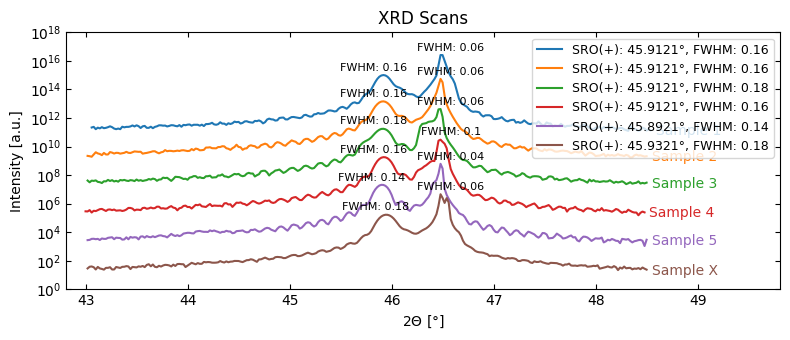

In [4]:
Xs, Ys = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
diff = 1e2

plot_xrd((Xs, Ys, length_list), sample_names, title='XRD Scans', 
         xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, 
         fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

legend = []
for i, (X, Y, sample_name, color) in enumerate(zip(Xs, Ys, sample_names, colors)):
    # Detect peaks
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)
    
    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    fwhm_sto, y_fwhm_sto, x_left_sto, x_right_sto = calculate_fwhm(X, Y, peak_x[0])
    fwhm_sro, y_fwhm_sro, x_left_sro, x_right_sro = calculate_fwhm(X, Y, peak_x[1])

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, FWHM: {fwhm_sro:.2f}'
    legend.append(legend_item)

    # Adjust y-values for plotting
    peak_y = np.array(peak_y) * diff ** (len(Ys) - i - 1)

    # Draw FWHM arrows for both peaks
    ax.text(peak_x[0]+0.1, peak_y[0] * 2, f'FWHM: {fwhm_sto:.2}',
            ha='center', fontsize=8)
    ax.text(peak_x[1]-0.1, peak_y[1] * 2, f'FWHM: {fwhm_sro:.2f}',
            ha='center', fontsize=8)

# Add legend and adjust layout
plt.legend(legend, fontsize=9)
plt.tight_layout()
plt.show()

### 2.5 Summarized XRD Scans (Scripts)

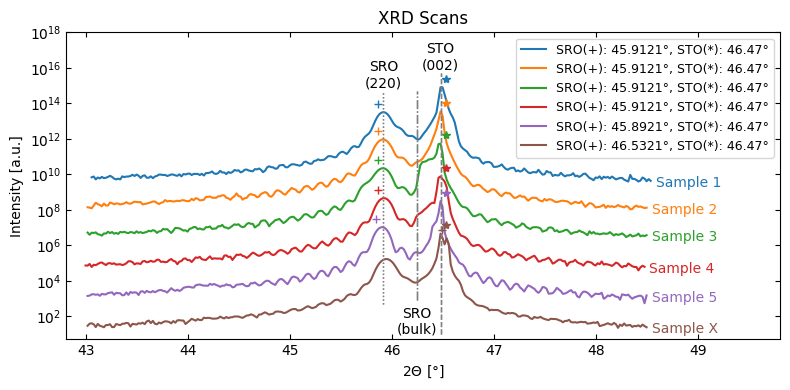

In [5]:
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = layout_fig(1, 1, figsize=(8, 4), layout='tight')
diff = 5e1
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 5e15], style=line_style)
ax.text(STO_x_peak, 8e15, 'STO\n(002)', fontsize=10, ha='center')

ax.text(45.9121, 8e14, 'SRO\n(220)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[45.9121, 45.9121], y_values=[5e2, 5e14], style=line_style)

ax.text(SRO_bulk_x_peak, 10, 'SRO\n(bulk)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dashdot', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[8e2, 5e14], style=line_style)

legend = []
for i, (X, Y, sample_name, color) in enumerate(zip(Xs_aligned, Ys_aligned, sample_names, colors)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=None)

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend.append(legend_item)
    
    peak_y = np.array(peak_y)*diff**(len(Ys)-i-1)
    plt.plot(peak_x[0]+0.05, peak_y[0]*3, '*', color=color)
    plt.plot(peak_x[1]-0.05, peak_y[1]*3, '+', color=color)
    
plt.ylim(5, 1e18)
plt.legend(legend, fontsize=9, loc='upper right')
plt.show()

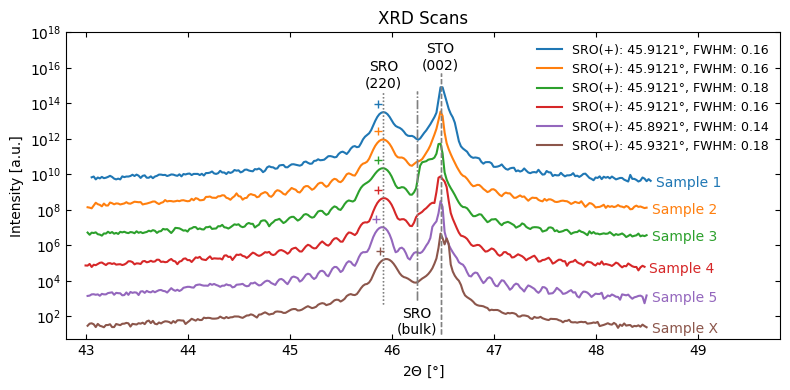

In [45]:
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = layout_fig(1, 1, figsize=(8, 4), layout='tight')
diff = 5e1
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 5e15], style=line_style)
ax.text(STO_x_peak, 8e15, 'STO\n(002)', fontsize=10, ha='center')

ax.text(45.9121, 8e14, 'SRO\n(220)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[45.9121, 45.9121], y_values=[5e2, 5e14], style=line_style)

ax.text(SRO_bulk_x_peak, 10, 'SRO\n(bulk)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dashdot', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[8e2, 5e14], style=line_style)

legend = []
for i, (X, Y, sample_name, color) in enumerate(zip(Xs_aligned, Ys_aligned, sample_names, colors)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)

    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    fwhm_sto, y_fwhm_sto, x_left_sto, x_right_sto = calculate_fwhm(X, Y, peak_x[0])
    fwhm_sro, y_fwhm_sro, x_left_sro, x_right_sro = calculate_fwhm(X, Y, peak_x[1])

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, FWHM: {fwhm_sro:.2f}'
    legend.append(legend_item)
    
    peak_y = np.array(peak_y)*diff**(len(Ys)-i-1)
    # plt.plot(peak_x[0], peak_y[0]*3, '*', color=color)
    plt.plot(peak_x[1]-0.05, peak_y[1]*3, '+', color=color)
    
plt.ylim(5, 1e18)
plt.legend(legend, fontsize=9, loc='upper right', frameon=False)
plt.savefig('../figures/s3_XRD_Scans.png', dpi=600)
plt.savefig('../figures/s3_XRD_Scans.svg', dpi=600)
plt.show()

Fig. s3 X-ray diffraction scans of SrRuO3 samples in the range of 43 - 48.5 degrees in 2θ angle, which is the desired range to evaluate bottom SrTiO3 substrate and SrRuO3 thin film.

## 3. Reciprocal Space Mapping (RSM)

In [ ]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
        '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG063/YG063 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',]
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
STO_x_peak = 46.4721
SRO_bulk_x_peak = 46.2425

Xs, Ys, length_list = load_xrd_scans(files)
for i, (X, Y, sample_name) in enumerate(zip(Xs, Ys, sample_names)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

### 3.1 RSMs along (103) - Summary

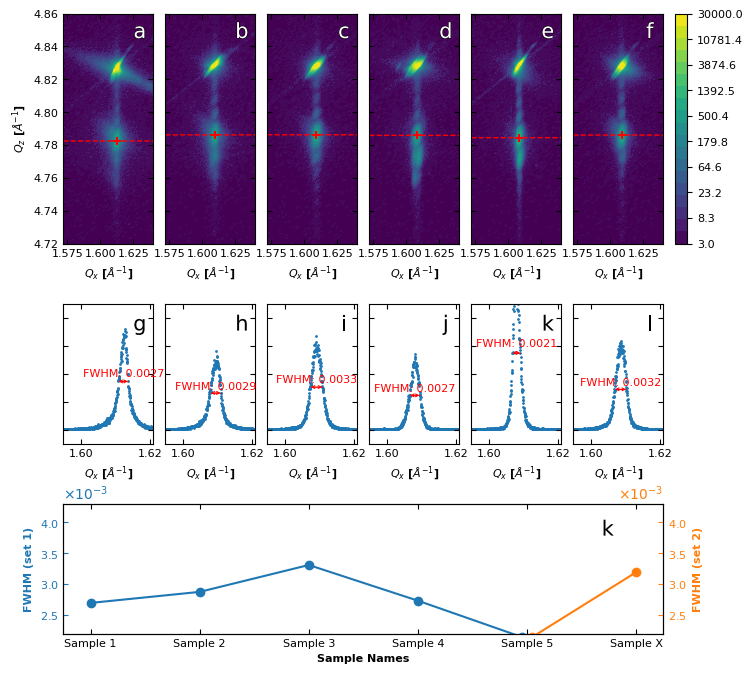

In [64]:
files = ['../data/XRD_RSM/YG065/YG065 STO RSM 103 phi at -172.74 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG066/set2/YG066 STO 103 phi 2.42 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG067/YG067 STO 103 phi_-93.77 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG068/YG068 STO 103 RSM phi at -86 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG069/set2/YG069 STO 103 RSM phi at -176.71 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG063/YG063 RSM 103 phi-272.45 slow 3 degree_1.xrdml']
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']

plot_params_103 = {
    "xlim": (1.572, 1.64),
    "ylim": (4.72, 4.86),
    "vmax": 30000,
}

plotter = RSMPlotter(plot_params_103)
fig, axes_dict = set_fig_axes()
Qx_lines, intensity_lines = plot_rsm_figure(plotter, fig, axes_dict, files, sample_names, peak_z_range=(4.78, 4.80), draw_peak=True, draw_peak_line=True)
FWHM_list = plot_fwhm_line_profile_figure(plotter, axes_dict, sample_names, Qx_lines, intensity_lines)
plot_fwhm_trend_figure(plotter, axes_dict, sample_names, FWHM_list)

plt.savefig('../figures/1_RSM_103_Analysis.png', dpi=1000, bbox_inches='tight')
plt.savefig('../figures/1_RSM_103_Analysis.svg', dpi=1000, bbox_inches='tight')
plt.show()

### 3.2  RSMs along (103) - Step by step guide

#### 3.2.1 Line profile along the RSM peaks

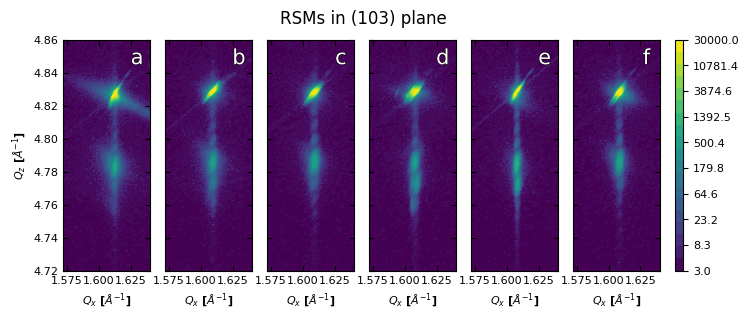

In [65]:
files = ['../data/XRD_RSM/YG065/YG065 STO RSM 103 phi at -172.74 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG066/set2/YG066 STO 103 phi 2.42 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG067/YG067 STO 103 phi_-93.77 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG068/YG068 STO 103 RSM phi at -86 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG069/set2/YG069 STO 103 RSM phi at -176.71 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG063/YG063 RSM 103 phi-272.45 slow 3 degree_1.xrdml']
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
graph, mod = 7, 7
width_ratios = [1, 1, 1, 1, 1, 1, 0.1]
fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')
for i, (ax, file, title) in enumerate(zip(axes, files, sample_names)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
plt.suptitle('RSMs in (103) plane')
# plt.savefig('../figures/1_RSMs_plain.png', dpi=300, bbox_inches='tight')
plt.show()

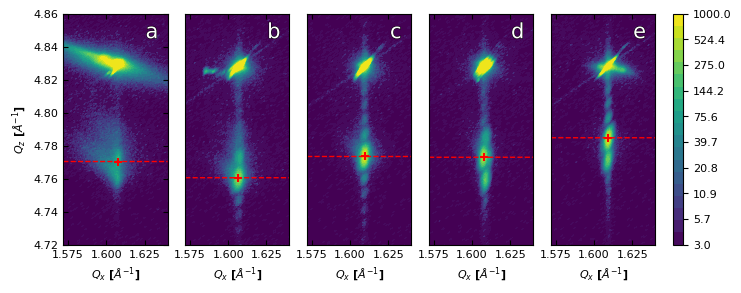

In [93]:
graph, mod = 6, 6
width_ratios = [1, 1, 1, 1, 1, 0.1]
fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', 
                       width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')
Qx_lines, intensity_lines = [], []
for i, (ax, file, title) in enumerate(zip(axes[:len(files)], files, sample_names)):
    
# Draw RSMs
    Qx, Qz, intensity = plotter.plot(file, fig, axes[:mod], ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')

# Mark peaks with red '+' 
    # Mark peaks with red '+'
    coordinates = peak_local_max(intensity, min_distance=20, threshold_abs=80, num_peaks=10)
    coordinates_target = []
    for j, z in enumerate(Qz[coordinates[:, 0], coordinates[:, 1]]):
        if z < 4.8:
            coordinates_target.append(coordinates[j])
    coordinates_target = np.array(coordinates_target)[:1]
    Qx_target, Qz_target = Qx[coordinates_target[:, 0], coordinates_target[:, 1]], Qz[coordinates_target[:, 0], coordinates_target[:, 1]]
    ax.scatter(Qx_target, Qz_target, marker='+', color='red')  # Mark peaks with red '+'
    
# draw a horizontal line
    # extract line profile at Qz_target
    mask = np.isclose(Qz, Qz_target, atol=1e-3)  # Boolean mask
    Qx_line = Qx[mask]
    intensity_line = intensity[mask]
    # sort the Qx_line and intensity_line based on Qx values
    Qx_index = np.argsort(Qx_line)
    Qx_line = Qx_line[Qx_index]
    intensity_line = intensity_line[Qx_index]
    
    Qz_line = np.ones_like(Qx_line) * Qz_target[0]
    ax.plot(Qx_line, Qz_line, 'r--', lw=1)
    
    Qx_lines.append(Qx_line)
    intensity_lines.append(intensity_line)

# plt.suptitle('RSMs in (103) plane')
plt.savefig('../figures/2_RSMs_SRO_peak.png', dpi=600, bbox_inches='tight')
plt.savefig('../figures/2_RSMs_SRO_peak.svg', dpi=600, bbox_inches='tight')
plt.show()

Fig. 2 Reciprocal Space Mappings (RSMs) visualization and analysis.
$\mathbf{a-e}$ RSMs visualization for 5 samples along the (103) direction. Prefered Q_x and Q_z regions are cropped for better visualization. Peaks for SRO is labeled with red "+" mark while the horizontal line drawed along marked peak. 

#### 3.2.2 Diffraction intensity along peak line profiles

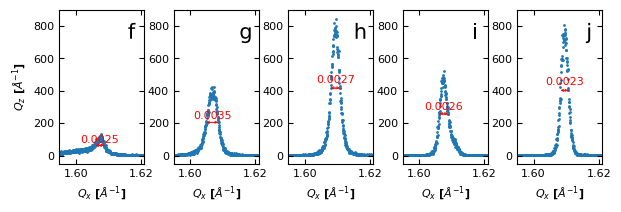

In [5]:
FWHM_list = []

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(7, 2), subplot_style='gridspec', spacing=(0.35, 0.1), layout='tight')
for i, (ax, Qx_line, intensity_line) in enumerate(zip(axes, Qx_lines, intensity_lines)):
    ax.scatter(Qx_line, intensity_line, s=1)

    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    peak_x, peak_y = detect_peaks(Qx_line, intensity_line, num_peaks=1, prominence=0.1, distance=None)
    fwhm, y_fwhm, x_left, x_right = calculate_fwhm(Qx_line, intensity_line, peak_x[0])

    # Draw FWHM arrows for both peaks
    ax.plot([x_left, x_right], [y_fwhm, y_fwhm], 'r-', lw=0.5)  # 'k-' is for black line
    # No shrink at the starting point and ending point and Controls arrowhead size
    ax.annotate('', xy=(x_right, y_fwhm), xytext=(x_left, y_fwhm),
                arrowprops=dict(arrowstyle='<->', lw=0.6, color='r', shrinkA=0,  shrinkB=0, mutation_scale=4))
    ax.text((x_left + x_right) / 2, y_fwhm*1.05, f'{fwhm:.4f}', ha='center', va='bottom', color='r', fontsize=8)
    
    ax.set_xlim(1.595, 1.621)
    ax.set_ylim(-50, 900)
    ax.tick_params(axis="x", direction="in", top=True, labelsize=plot_params.get("fontsize", 12))
    ax.tick_params(axis="y", direction="in", right=True, labelsize=plot_params.get("fontsize", 12))     
    ax.set_xlabel(r'$Q_x$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
    labelfigs(ax, i+5, size=15, inset_fraction=(0.15, 0.15), loc='tr', style='bw')
    
    FWHM_list.append(fwhm)
    
axes[0].set_ylabel(r'$Q_z$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
plt.savefig('../figures/2_RSMs_SRO_FWHM.png', dpi=600, bbox_inches='tight')
plt.savefig('../figures/2_RSMs_SRO_FWHM.svg', dpi=600, bbox_inches='tight')
plt.show()

Fig. 2 Reciprocal Space Mappings (RSMs) visualization and analysis.
$\mathbf{f-j}$ Line profile alone the RSM peaks horizontally for sample 1-5, respectively. 

#### 3.2.3 FWHM trend

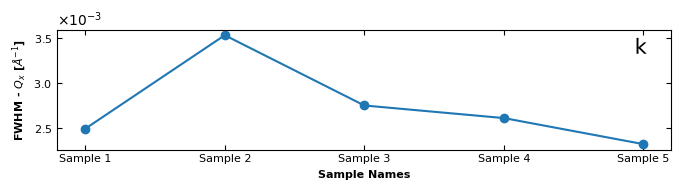

In [ ]:
fig, ax = layout_fig(graph=1, mod=1, figsize=(7, 2), layout='tight')

ax.plot(sample_names, FWHM_list, marker='o')
labelfigs(ax, 10, size=15, inset_fraction=(0.15, 0.05), loc='tr', style='bw')

ax.set_xlabel('Sample Names', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
ax.set_ylabel(r'FWHM - $Q_x$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
ax.tick_params(axis="x", direction="in", top=True, labelsize=plot_params.get("fontsize", 12))
ax.tick_params(axis="y", direction="in", right=True, labelsize=plot_params.get("fontsize", 12))    
    
# Set the y-axis to scientific notation
formatter = ScalarFormatter(useMathText=True)  # Use MathText for cleaner output
formatter.set_scientific(True)  # Enable scientific notation
formatter.set_powerlimits((1, 10))  # Set when to switch to scientific notation
ax.yaxis.set_major_formatter(formatter)  # Apply formatter to y-axis

plt.tight_layout()
plt.savefig('../figures/2_RSMs_SRO_FWHM_trend.png', dpi=600, bbox_inches='tight')
plt.savefig('../figures/2_RSMs_SRO_FWHM_trend.svg', dpi=600, bbox_inches='tight')
plt.show()

Fig. 2 Reciprocal Space Mappings (RSMs) visualization and analysis.
$\mathbf{k}$ FWHM line plot for samples differences.

#### 3.2.4 Summary plot of RSMs

In [ ]:
width_margin = 0.12
first_row_y, first_row_width, first_row_height = 0, 1.1, 2.5
second_row_y, second_row_width, second_row_height = 3.1, 1.1, 1.6
third_row_y, third_row_width, third_row_height = 5.3, 6, 1.3

subfigures_dict = {
                    '1_1': {"position": [0, first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5}, # [left, bottom, width, height]
                    '1_2': {"position": [(first_row_width+width_margin), first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5},
                    '1_3': {"position": [2*(first_row_width+width_margin), first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5},
                    '1_4': {"position": [3*(first_row_width+width_margin), first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5},
                    '1_5': {"position": [4*(first_row_width+width_margin), first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5},
                    '1_6': {"position": [5*(first_row_width+width_margin), first_row_y, 0.12, first_row_height], 'skip_margin': True, 'margin_pts':5},

                    '2_1': {"position": [0, second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},
                    '2_2': {"position": [(second_row_width+width_margin), second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},
                    '2_3': {"position": [2*(second_row_width+width_margin), second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},
                    '2_4': {"position": [3*(second_row_width+width_margin), second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},
                    '2_5': {"position": [4*(second_row_width+width_margin), second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},

                    '3_1': {"position": [0, third_row_y, third_row_width, third_row_height], 'skip_margin': True, 'margin_pts':5},
                    }
for key, value in subfigures_dict.items():
    subfigures_dict[key]["position"] = convert_top_left_origin_to_matplotlib(value["position"], fig)
# fig, axes_dict = layout_subfigures_inches((8,6), subfigures_dict)

plot_params_103 = {
    "xlim": (1.572, 1.64),
    "ylim": (4.72, 4.86),
}
plotter = RSMPlotter(plot_params_103)

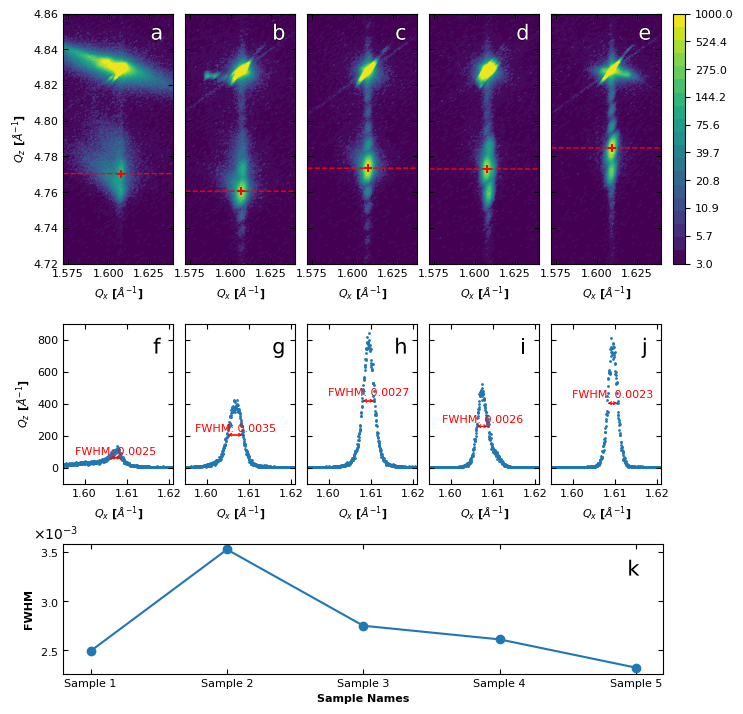

In [ ]:
fig, axes_dict = layout_subfigures_inches((8,6), subfigures_dict)
axes = list(axes_dict.values())

for i, (ax, file, title) in enumerate(zip(axes[:len(files)], files, sample_names)):
    
# Draw RSMs
    Qx, Qz, intensity = plotter.plot(file, fig, axes[:6], ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')

# Mark peaks with red '+' and draw a horizontal line
    # Mark peaks with red '+'
    coordinates = peak_local_max(intensity, min_distance=20, threshold_abs=80, num_peaks=10)
    coordinates_target = []
    for j, z in enumerate(Qz[coordinates[:, 0], coordinates[:, 1]]):
        if z < 4.8:
            coordinates_target.append(coordinates[j])
    coordinates_target = np.array(coordinates_target)[:1]
    Qx_target, Qz_target = Qx[coordinates_target[:, 0], coordinates_target[:, 1]], Qz[coordinates_target[:, 0], coordinates_target[:, 1]]
    ax.scatter(Qx_target, Qz_target, marker='+', color='red')  # Mark peaks with red '+'
    
    # extract line profile at Qz_target
    mask = np.isclose(Qz, Qz_target, atol=1e-3)  # Boolean mask
    Qx_line = Qx[mask]
    intensity_line = intensity[mask]
    # sort the Qx_line and intensity_line based on Qx values
    Qx_index = np.argsort(Qx_line)
    Qx_line = Qx_line[Qx_index]
    intensity_line = intensity_line[Qx_index]
    
    Qz_line = np.ones_like(Qx_line) * Qz_target[0]
    ax.plot(Qx_line, Qz_line, 'r--', lw=1)
    
# plot the line profile and mark the peak, FWHM
    ax = axes[i+6] # change to second row
    ax.scatter(Qx_line, intensity_line, s=1)

    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    peak_x, peak_y = detect_peaks(Qx_line, intensity_line, num_peaks=1, prominence=0.1, distance=None)
    fwhm, y_fwhm, x_left, x_right = calculate_fwhm(Qx_line, intensity_line, peak_x[0])

# Draw FWHM arrows for both peaks
    ax.plot([x_left, x_right], [y_fwhm, y_fwhm], 'r-', lw=0.5)  # 'k-' is for black line
    # No shrink at the starting point and ending point and Controls arrowhead size
    ax.annotate('', xy=(x_right, y_fwhm), xytext=(x_left, y_fwhm),
                arrowprops=dict(arrowstyle='<->', lw=0.8, color='r', shrinkA=0,  shrinkB=0, mutation_scale=5))
    ax.text((x_left + x_right) / 2, y_fwhm*1.05, f'FWHM: {fwhm:.4f}', ha='center', va='bottom', color='r', fontsize=8)
    ax.set_ylim(-100, 900)
    ax.set_xlim(1.595, 1.621)
    
    ax.tick_params(axis="x", direction="in", top=True, labelsize=plot_params.get("fontsize", 12))
    ax.tick_params(axis="y", direction="in", right=True, labelsize=plot_params.get("fontsize", 12))       
    ax.set_xlabel(r'$Q_x$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
    ax.set_ylabel(r'$Q_z$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
    labelfigs(ax, i+5, size=15, inset_fraction=(0.15, 0.15), loc='tr', style='bw')
    
    # adjust the yticks and ylabel for the line profile plots
axes[6].set_ylabel(r'$Q_z$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12))
for ax in axes[7:-1]: # start from second ax in the second row
    ax.set_yticklabels([])
    ax.set_ylabel('')

# plot the trend of FWHM
axes[-1].plot(sample_names, FWHM_list, marker='o')
axes[-1].set_xlabel('Sample Names', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
axes[-1].set_ylabel(r'FWHM', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
axes[-1].tick_params(axis="x", direction="in", top=True, labelsize=plot_params.get("fontsize", 12))
axes[-1].tick_params(axis="y", direction="in", right=True, labelsize=plot_params.get("fontsize", 12)) 
labelfigs(axes[-1], 10, size=15, inset_fraction=(0.2, 0.05), loc='tr', style='bw')
    
# Set the y-axis to scientific notation
formatter = ScalarFormatter(useMathText=True)  # Use MathText for cleaner output
formatter.set_scientific(True)  # Enable scientific notation
formatter.set_powerlimits((1, 10))  # Set when to switch to scientific notation
axes[-1].yaxis.set_major_formatter(formatter)  # Apply formatter to y-axis
axes[-1].yaxis.get_offset_text().set_x(-0.05)  # Set horizontal position (relative to the axis)

# plt.savefig('../figures/2_RSM_Analysis.png', dpi=1000, bbox_inches='tight')
# plt.savefig('../figures/2_RSM_Analysis.svg', dpi=1000, bbox_inches='tight')
plt.show()

Fig. 2 Reciprocal space Mapping for 5 samples along the (103) direction. Prefered Q_x and Q_z regions are cropped for better visualization.
$\mathbf{a-e}$ RSMs visualization for 5 samples along the (103) direction. Prefered Q_x and Q_z regions are cropped for better visualization. Peaks for SRO is labeled with red "+" mark while the horizontal line drawed along marked peak. 
$\mathbf{f-j}$ Line profile alone the RSM peaks horizontally for sample 1-5, respectively. 
$\mathbf{k}$ FWHM line plot for samples differences.

### 3.1 RSMs along (002) - Summary

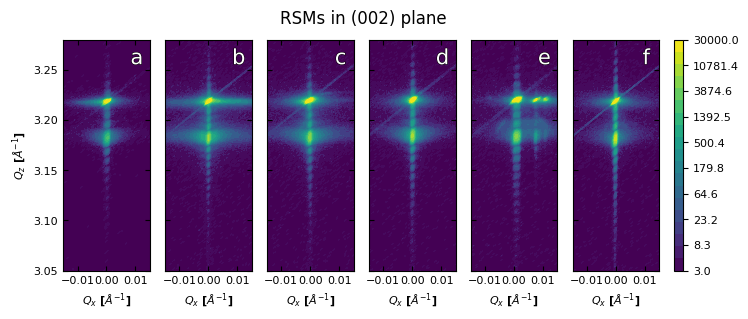

In [76]:
plot_params_002 = {
    "xlim": (-0.015, 0.015),
    "ylim": (3.05, 3.28),
    "vmax": 30000,
}
plotter = RSMPlotter(plot_params_002)

files = ['../data/XRD_RSM/YG063/YG063 RSM 002 phi-91.57 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG065/YG065 STO RSM 002 phi at 6.81 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG066/YG066 STO 002 phi 2.42 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG067/YG067 STO 002 phi -93.06 degree scan.xrdml',
         '../data/XRD_RSM/YG068/YG068 STO 002 RSM phi at 3.05 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG069/YG069 STO 002 RSM phi at 3.18 slow 3 degree_1.xrdml',
]
sample_names = ['Sample X', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']
graph, mod = 7, 7
width_ratios = [1, 1, 1, 1, 1, 1,0.1]
fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', 
                       width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')

for i, (ax, file, title) in enumerate(zip(axes, files, sample_names)):
# Draw RSMs
    Qx, Qz, intensity = plotter.plot(file, fig, axes[:mod], ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    
plt.suptitle('RSMs in (002) plane')
plt.show()
# Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG063/YG063 RSM 002 phi-91.57 slow 3 degree_1.xrdml', figsize=(2,4))
# # Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG065/', figsize=(2,4))
# Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG066/YG066 STO 002 phi 2.42 RSM slow 3 degree_1.xrdml', figsize=(2,4))
# # Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG067/', figsize=(2,4))
# # Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG068/', figsize=(2,4))
# Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG069/YG069 STO 002 RSM phi at 3.18 slow 3 degree_1.xrdml', figsize=(2,4))

### 3.4 Four angles RSM scans along (103)

In [ ]:
plot_params_103 = {
    "xlim": (1.572, 1.64),
    "ylim": (4.72, 4.86),
}
plotter = RSMPlotter(plot_params_103)

['../data/XRD_RSM/YG063\\YG063 RSM 103 phi-1.35 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG063\\YG063 RSM 103 phi-91.57 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG063\\YG063 RSM 103 phi-182.21 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG063\\YG063 RSM 103 phi-272.45 slow 3 degree_1.xrdml']


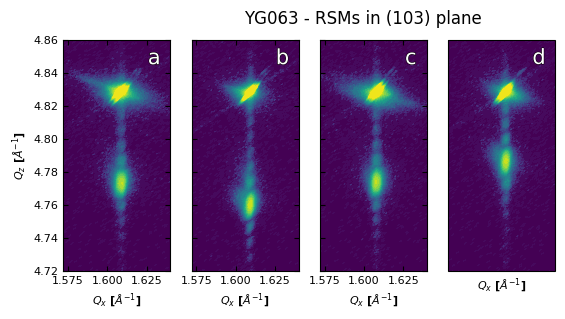

In [52]:
# No RSM scans
files = glob.glob('../data/XRD_RSM/YG063/*RSM*103*.xrdml')
files = [files[i] for i in [0,3,1,2]]
print(files)
fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
plt.suptitle('YG063 - RSMs in (103) plane')
# plt.tight_layout()
plt.show()

['../data/XRD_RSM/YG065\\YG065 STO RSM 103 phi at -263 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG065\\YG065 STO RSM 103 phi at -172.74 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG065\\YG065 STO RSM 103 phi at -83.1 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG065\\YG065 STO RSM 103 phi at 6.81 slow 3 degree_1.xrdml']


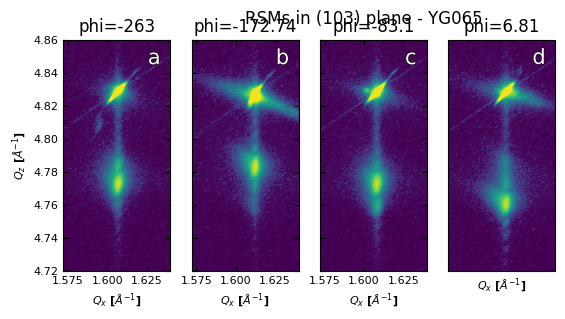

In [53]:
# 1 RSM scans
files = glob.glob('../data/XRD_RSM/YG065/YG065*RSM*')
files = [files[i] for i in [1,0,2,3]]
print(files)
fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    pattern = r"phi(?:[_ ]| at )(-?\d+\.?\d*)"
    label = 'phi='+re.search(pattern, file).group(1)
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    # ax.set_title(label)
plt.suptitle('RSMs in (103) plane - YG065')
# plt.tight_layout()
plt.show()

['../data/XRD_RSM/YG066/set1\\YG066 STO 103 phi_-85.36 RSM slow 3 degree_1.xrdml', '../data/XRD_RSM/YG066/set1\\YG066 STO 103 phi_4.64 RSM slow 3 degree_1.xrdml', '../data/XRD_RSM/YG066/set1\\YG066 STO 103 phi 94.64 RSM slow 3 degree_1.xrdml', '../data/XRD_RSM/YG066/set1\\YG066 STO 103 phi_184.64 RSM slow 3 degree_1.xrdml']


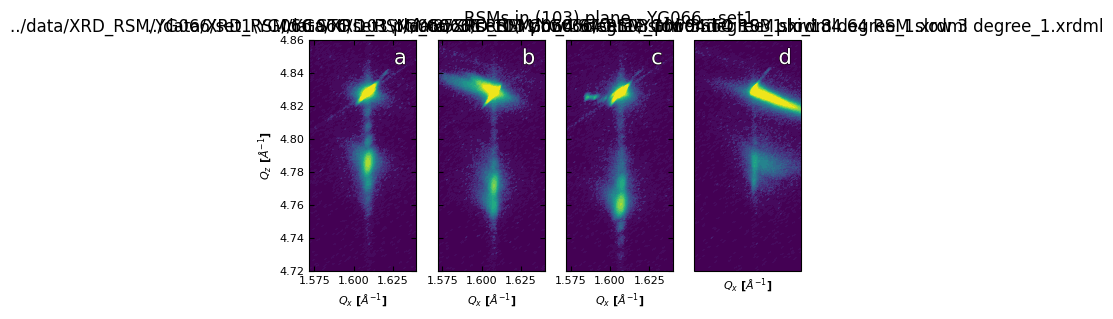

In [54]:
# 4 RSM scans, but need to redo for better result
files = glob.glob('../data/XRD_RSM/YG066/set1/YG066*RSM*.xrdml')
files = [files[i] for i in [1,3,0,2]]
print(files)

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    ax.set_title(file)
plt.suptitle('RSMs in (103) plane - YG066 - set1')
# plt.tight_layout()
plt.show()

['../data/XRD_RSM/YG066/set2\\YG066 STO 103 phi -267 RSM slow 3 degree_1.xrdml', '../data/XRD_RSM/YG066/set2\\YG066 STO 103 phi -177.09 RSM slow 3 degree_1.xrdml', '../data/XRD_RSM/YG066/set2\\YG066 STO 103 phi -87.58 RSM slow 3 degree_1.xrdml', '../data/XRD_RSM/YG066/set2\\YG066 STO 103 phi 2.42 RSM slow 3 degree_1.xrdml']


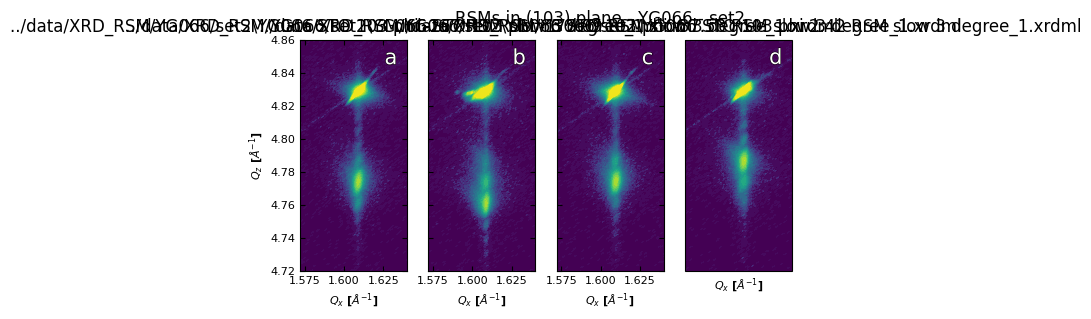

In [55]:
# 4 RSM scans, but need to redo for better result
files = glob.glob('../data/XRD_RSM/YG066/set2/YG066*RSM*.xrdml')
files = [files[i] for i in [1,0,2,3]]
print(files)

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    ax.set_title(file)
plt.suptitle('RSMs in (103) plane - YG066 - set2')
# plt.tight_layout()
plt.show()

['../data/XRD_RSM/YG067\\YG067 STO 103 phi_-3.77 RSM slow 3 degree_1 1.xrdml', '../data/XRD_RSM/YG067\\YG067 STO 103 phi_-273.77 RSM slow 3 degree_1.xrdml', '../data/XRD_RSM/YG067\\YG067 STO 103 phi_-183.77 RSM slow 3 degree_1.xrdml', '../data/XRD_RSM/YG067\\YG067 STO 103 phi_-93.77 RSM slow 3 degree_1.xrdml']


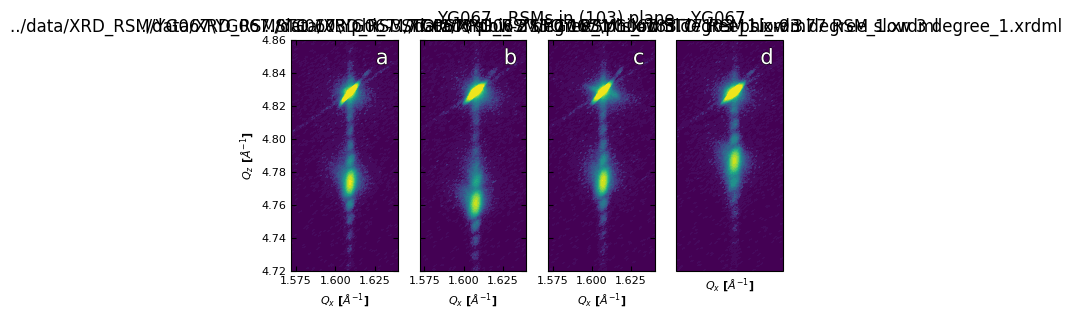

In [58]:
# 4 RSM scans, done
files = glob.glob('../data/XRD_RSM/YG067/YG067*RSM*.xrdml')
files = [files[i] for i in [2,1,0,3]]
print(files)

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    pattern = r"phi(?:[_ ]| at )(-?\d+\.?\d*)"
    label = 'phi='+re.search(pattern, file).group(1)
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    ax.set_title(file)
plt.suptitle('YG067 - RSMs in (103) plane - YG067')
# plt.tight_layout()
plt.show()

['../data/XRD_RSM/YG068\\YG068 STO 103 RSM phi at -356 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG068\\YG068 STO 103 RSM phi at -266 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG068\\YG068 STO 103 RSM phi at -176 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG068\\YG068 STO 103 RSM phi at -86 slow 3 degree_1.xrdml']


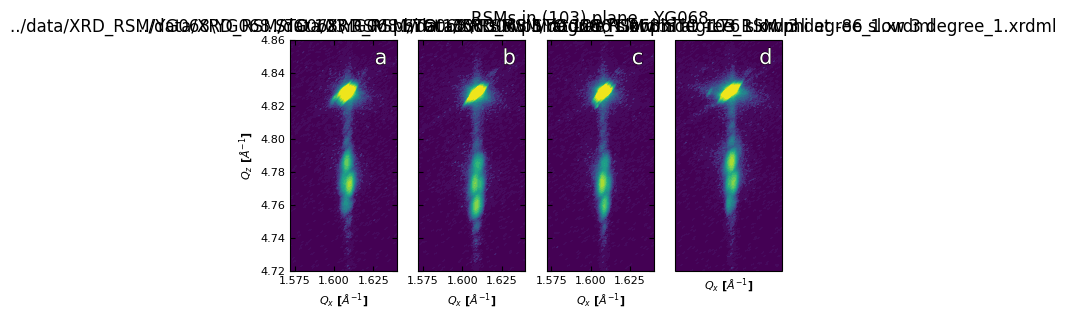

In [56]:
# 4 RSM scans, done
files = glob.glob('../data/XRD_RSM/YG068/YG068*RSM*.xrdml')
files = [files[i] for i in [2,1,0,3]]
print(files)

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    pattern = r"phi(?:[_ ]| at )(-?\d+\.?\d*)"
    label = 'phi='+re.search(pattern, file).group(1)
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    ax.set_title(file)
plt.suptitle('RSMs in (103) plane - YG068')
# plt.tight_layout()
plt.show()

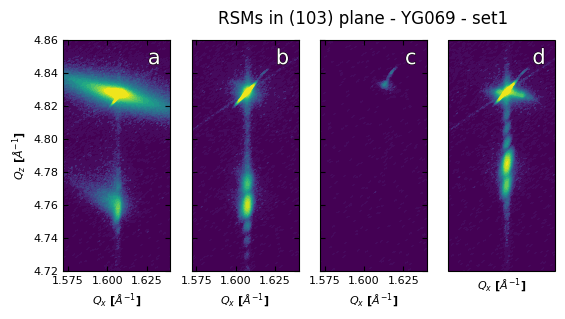

In [28]:
# 4 RSM scans, but need to redo for better result
files = glob.glob('../data/XRD_RSM/YG069/set1/YG069*RSM*.xrdml')
files = [files[i] for i in [2,1,0,3]]

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    pattern = r"phi(?:[_ ]| at )(-?\d+\.?\d*)"
    label = 'phi='+re.search(pattern, file).group(1)
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
plt.suptitle('RSMs in (103) plane - YG069 - set1')
# plt.tight_layout()
plt.show()

['../data/XRD_RSM/YG069/set2\\YG069 STO 103 RSM phi at -266.17 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG069/set2\\YG069 STO 103 RSM phi at -176.71 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG069/set2\\YG069 STO 103 RSM phi at -87.03 slow 3 degree_1.xrdml', '../data/XRD_RSM/YG069/set2\\YG069 STO 103 RSM phi at 3.18 slow 3 degree_1.xrdml']


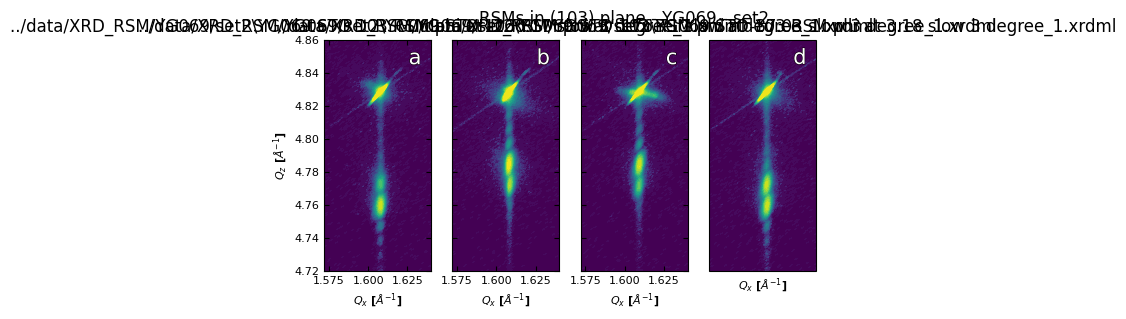

In [57]:
# 4 RSM scans, but need to redo for better result
files = glob.glob('../data/XRD_RSM/YG069/set2/YG069*103*RSM*.xrdml')
files = [files[i] for i in [1,0,2,3]]
print(files)

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    pattern = r"phi(?:[_ ]| at )(-?\d+\.?\d*)"
    label = 'phi='+re.search(pattern, file).group(1)
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    ax.set_title(file)
plt.suptitle('RSMs in (103) plane - YG069 - set2')
# plt.tight_layout()
plt.show()

Fig. s1.1 RSMs in different phi angles. a, b, c, d is 0, 90, 180, 270 degrees, respectively.